In [1]:
# Import basic modules
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from scipy.stats import norm

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.pipeline import make_pipeline

plt.style.use('bmh')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
merge_data = pd.read_csv('tenant_energy_clean_data.csv')
merge_data['date_time'] = pd.to_datetime(merge_data['date_time'])
merge_data.head()

,date_time,electric_consumption,electric_demand,steam_consumption,steam_demand,temp,humidity,electric_cum_consumption,electric_cum_demand,steam_cum_consumption,...,tenant_17_consumption,tenant_17_demand,tenant_17_cum_consumption,tenant_18_consumption,tenant_18_demand,tenant_18_cum_consumption,all_tenants_consumption,all_tenants_cum_consumption,date,entries
0,2018-01-01 00:15:00,430.0,1720.0,4800.0,18700.0,9.000,56.100,430.0,1720.0,4800.0,...,0.2,1.2,0.2,0.0,0.0,0.0,15.2,15.2,2018-01-01,NaN
1,2018-01-01 00:30:00,420.0,1700.0,4480.0,18560.0,9.000,56.100,850.0,3420.0,9280.0,...,0.2,0.8,0.4,0.0,0.0,0.0,16.0,31.2,2018-01-01,NaN
2,2018-01-01 00:45:00,440.0,1720.0,5350.0,19660.0,9.000,56.100,1290.0,5140.0,14630.0,...,0.4,1.2,0.8,0.2,0.4,0.2,15.5,46.7,2018-01-01,NaN
3,2018-01-01 01:00:00,420.0,1720.0,5660.0,22020.0,9.000,56.100,1710.0,6860.0,20290.0,...,0.4,1.6,1.2,0.0,0.4,0.2,15.3,62.0,2018-01-01,NaN
4,2018-01-01 01:15:00,420.0,1680.0,5660.0,22640.0,8.975,56.125,2130.0,8540.0,25950.0,...,0.2,1.2,1.4,0.0,0.0,0.2,15.3,77.3,2018-01-01,NaN


In [3]:
# time_features
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def date_time_features(date_time):
    date_time['year'] = date_time['date_time'].dt.year
    date_time['month'] = date_time['date_time'].dt.month
    date_time['day'] = date_time['date_time'].dt.day
    date_time['hour'] = date_time['date_time'].dt.hour
    date_time['quater'] = date_time['date_time'].dt.minute.apply(lambda x: 0 if x==0 else 1 if x==15 else 2 if x==30 else 3)
    date_time['weekday'] = date_time['date_time'].dt.weekday
    
    #date_time['weekofyear'] = date_time['date_time'].dt.week
    #date_time['dayofyear'] = date_time['date_time'].dt.dayofyear
      
    date_time['is_weekend'] = date_time['date_time'].dt.weekday.apply(lambda x: 1 if x in [5,6] else 0)
    cal = calendar()
    date_time['is_holiday'] = date_time['date_time'].dt.date.astype('datetime64').isin(cal.holidays(start=date_time['date_time'].min(), end=date_time['date_time'].max())).astype(int)
    date_time['daytime_range'] = date_time['date_time'].dt.hour.apply(lambda x: 'Morning' if x in [7,8,9,10,11] else \
                                                                               'Afternoon' if x in [12,13,14,15,16,17] else \
                                                                               'Evening' if x in [18,19,20,21] else
                                                                               'Night')
    date_time['after_032020'] = date_time['date_time'].dt.strftime('%Y-%m-%d').apply(lambda x: 1 if x>='2020-03-20' else 0)
    return date_time

In [4]:
date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-09-01', freq='15T'), columns=['date_time'])
date_time = date_time_features(date_time)
date_time.head()

,date_time,year,month,day,hour,quater,weekday,is_weekend,is_holiday,daytime_range,after_032020
0,2018-01-01 00:15:00,2018,1,1,0,1,0,0,0,Night,0
1,2018-01-01 00:30:00,2018,1,1,0,2,0,0,0,Night,0
2,2018-01-01 00:45:00,2018,1,1,0,3,0,0,0,Night,0
3,2018-01-01 01:00:00,2018,1,1,1,0,0,0,0,Night,0
4,2018-01-01 01:15:00,2018,1,1,1,1,0,0,0,Night,0


In [5]:
merge_data = merge_data.merge(date_time, on='date_time')
merge_data = merge_data.set_index('date_time')
merge_data.head()

,electric_consumption,electric_demand,steam_consumption,steam_demand,temp,humidity,electric_cum_consumption,electric_cum_demand,steam_cum_consumption,steam_cum_demand,...,year,month,day,hour,quater,weekday,is_weekend,is_holiday,daytime_range,after_032020
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,430.0,1720.0,4800.0,18700.0,9.000,56.100,430.0,1720.0,4800.0,18700.0,...,2018,1,1,0,1,0,0,0,Night,0
2018-01-01 00:30:00,420.0,1700.0,4480.0,18560.0,9.000,56.100,850.0,3420.0,9280.0,37260.0,...,2018,1,1,0,2,0,0,0,Night,0
2018-01-01 00:45:00,440.0,1720.0,5350.0,19660.0,9.000,56.100,1290.0,5140.0,14630.0,56920.0,...,2018,1,1,0,3,0,0,0,Night,0
2018-01-01 01:00:00,420.0,1720.0,5660.0,22020.0,9.000,56.100,1710.0,6860.0,20290.0,78940.0,...,2018,1,1,1,0,0,0,0,Night,0
2018-01-01 01:15:00,420.0,1680.0,5660.0,22640.0,8.975,56.125,2130.0,8540.0,25950.0,101580.0,...,2018,1,1,1,1,0,0,0,Night,0


In [6]:
merge_data['tenant_1_consumption'].tail()

date_time
2020-08-31 23:00:00   NaN
2020-08-31 23:15:00   NaN
2020-08-31 23:30:00   NaN
2020-08-31 23:45:00   NaN
2020-09-01 00:00:00   NaN
Name: tenant_1_consumption, dtype: float64

In [7]:
merge_data.columns

Index(['electric_consumption', 'electric_demand', 'steam_consumption',
       'steam_demand', 'temp', 'humidity', 'electric_cum_consumption',
       'electric_cum_demand', 'steam_cum_consumption', 'steam_cum_demand',
       'tenant_1_consumption', 'tenant_1_demand', 'tenant_1_cum_consumption',
       'tenant_2_consumption', 'tenant_2_demand', 'tenant_2_cum_consumption',
       'tenant_3_consumption', 'tenant_3_demand', 'tenant_3_cum_consumption',
       'tenant_4_consumption', 'tenant_4_demand', 'tenant_4_cum_consumption',
       'tenant_5_consumption', 'tenant_5_demand', 'tenant_5_cum_consumption',
       'tenant_6_consumption', 'tenant_6_demand', 'tenant_6_cum_consumption',
       'tenant_7_consumption', 'tenant_7_demand', 'tenant_7_cum_consumption',
       'tenant_8_consumption', 'tenant_8_demand', 'tenant_8_cum_consumption',
       'tenant_9_consumption', 'tenant_9_demand', 'tenant_9_cum_consumption',
       'tenant_10_consumption', 'tenant_10_demand',
       'tenant_10_cum_consump

Linear Regression

In [8]:
#tenant_usage_meters = pd.read_csv('tenant_usage_meters.csv')
#tenant_usage_meters.head()

In [9]:
def error(y_test, y_predict, expm1=True):
    if expm1:
        y_test = np.expm1(y_test)
        y_predict = np.expm1(y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse)
    std = np.std(y_predict)
    return mse.round(6), rmse.round(6), std.round(6)

In [10]:
def train_test_split(data, test_col, test_size=0.15, log_y=True):
    test_index = int(len(df)*(1-test_size))
    
    X_train = data.drop(test_col, axis = 1).iloc[:test_index]
    y_train = data[test_col].iloc[:test_index]
    X_test = data.drop(test_col, axis = 1).iloc[test_index:]
    y_test = data[test_col].iloc[test_index:]
    
    if log_y==True:
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)
    
    return X_train, y_train, X_test, y_test

In [21]:
def train_test_split_by_date(data, test_col, test_date='2020-07-01', log_y=True):
    X_train = data[data.index<test_date].drop(test_col, axis = 1)
    y_train = data[data.index<test_date][test_col]
    X_test = data[data.index>=test_date].drop(test_col, axis = 1)
    y_test = data[data.index>=test_date][test_col]
    
    if log_y==True:
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)
    
    return X_train, y_train, X_test, y_test

In [12]:
def plot_test_predict(X_test_list, y_test_list, y_predict_list):
    for i in range(1, 19):
        X_test = X_test_list[i-1]
        y_test = y_test_list[i-1]
        y_predict = y_predict_list[i-1]
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
        ax1.plot(X_test.index, np.expm1(y_test), '.')
        ax1.plot(X_test.index, np.expm1(y_predict), '.')
        ax1.axhline(0, linewidth = 0.5, color = 'r')
        ax1.set_title('tenant '+str(i)+' test')

        ax2.plot(X_test.index, np.expm1(y_test).cumsum(), '-')
        ax2.plot(X_test.index, np.expm1(y_predict).cumsum(), '-')
        ax2.set_title('tenant '+str(i)+' predict') 

        plt.show()

In [13]:
data_lin = merge_data.copy()
#data_lin['entries'] = data_lin['entries'].interpolate().round()
data_lin['has_entries_data'] = data_lin['entries'].apply(lambda x: 0 if pd.isnull(x) else 1)
#data_lin['has_entries_data'] = data_lin['date_time'].dt.strftime('%Y-%m-%d').apply(lambda x: 0 if x<'2020-02-10' else 1)
data_lin = data_lin[[#'electric_consumption', 'electric_demand', 'electric_cum_consumption', 'electric_cum_demand',  
        #'steam_consumption', 'steam_demand', 'steam_cum_consumption', 'steam_cum_demand', 
        'temp', 'humidity', 'entries', 'has_entries_data',
        #'all_tenants_consumption', 'all_tenants_cum_consumption', 
        'year', 'month', 'day', 'hour', 'quater', 'weekday', #'weekofyear', 'dayofyear',
        'is_weekend', 'is_holiday', 'daytime_range', #'after_032020',
        'tenant_1_consumption', 'tenant_2_consumption', 'tenant_3_consumption', 'tenant_4_consumption', 
        'tenant_5_consumption', 'tenant_6_consumption', 'tenant_7_consumption', 'tenant_8_consumption', 
        'tenant_9_consumption', 'tenant_10_consumption', 'tenant_11_consumption', 'tenant_12_consumption', 
        'tenant_13_consumption', 'tenant_14_consumption', 'tenant_15_consumption', 'tenant_16_consumption', 
        'tenant_17_consumption', 'tenant_18_consumption']]

cat_cols = ['year', 'month', 'hour', 'quater', 'weekday', 'is_weekend', 'is_holiday', 'daytime_range']
for col in cat_cols:
    data_lin[col] = data_lin[col].astype('category')
data_lin = pd.get_dummies(data_lin)
    
data_lin.head()

,temp,humidity,entries,has_entries_data,day,tenant_1_consumption,tenant_2_consumption,tenant_3_consumption,tenant_4_consumption,tenant_5_consumption,...,weekday_5,weekday_6,is_weekend_0,is_weekend_1,is_holiday_0,is_holiday_1,daytime_range_Afternoon,daytime_range_Evening,daytime_range_Morning,daytime_range_Night
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,9.000,56.100,NaN,0,1,0.4,1.6,0.2,1.3,0.3,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 00:30:00,9.000,56.100,NaN,0,1,0.4,1.6,0.2,1.3,0.5,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 00:45:00,9.000,56.100,NaN,0,1,0.4,1.5,0.2,1.3,0.4,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 01:00:00,9.000,56.100,NaN,0,1,0.3,1.6,0.2,1.3,0.3,...,0,0,1,0,1,0,0,0,0,1
2018-01-01 01:15:00,8.975,56.125,NaN,0,1,0.4,1.5,0.3,1.3,0.3,...,0,0,1,0,1,0,0,0,0,1


In [18]:
data_lin[data_lin.index>='2020-08-31']

,temp,humidity,entries,has_entries_data,day,tenant_1_consumption,tenant_2_consumption,tenant_3_consumption,tenant_4_consumption,tenant_5_consumption,...,weekday_5,weekday_6,is_weekend_0,is_weekend_1,is_holiday_0,is_holiday_1,daytime_range_Afternoon,daytime_range_Evening,daytime_range_Morning,daytime_range_Night
date_time,,,,,,,,,,,,,,,,,,,,,
2020-08-31 00:00:00,73.40,40.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
2020-08-31 00:15:00,72.95,41.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
2020-08-31 00:30:00,72.50,42.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
2020-08-31 00:45:00,72.05,43.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
2020-08-31 01:00:00,71.60,44.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31 23:00:00,71.60,57.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
2020-08-31 23:15:00,71.60,57.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1
2020-08-31 23:30:00,71.60,57.0,234.0,1,31,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,1


In [80]:
from sklearn.linear_model import LinearRegression

lin_error = pd.DataFrame(columns=['tenant', 'mse', 'rmse', 'std', 'max_test', 'min_test', 'avg_test', 'max_predict', 'min_predict', 'avg_predict'])
lin_models = []
tests = []
predicts = []
lin_final_predict = pd.DataFrame()
lin_final_predict['date_time'] = pd.date_range('2020-08-31', '2020-09-01', freq='15T')
lin_final_predict = lin_final_predict.set_index('date_time')

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'day', 'entries', 'has_entries_data', 
                    'year_2018', 'year_2019', 'year_2020',
                    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                    'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                    'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                    'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'quater_0',
                    'quater_1', 'quater_2', 'quater_3', 'weekday_0', 'weekday_1',
                    'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                    'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                    'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night', 
                    test_col]]
    
    final = df[df.index>='2020-08-31'].drop(test_col, axis=1).fillna(0)
    
    df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    #df = df.dropna(subset=[test_col]).fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(df, test_col, test_size=0.15, log_y=False)
    
    
    lin = LinearRegression() 
    lin.fit(X_train, y_train)
    y_predict = lin.predict(X_test)
    y_predict[y_predict<0] = 0
    
    
    result = lin.predict(final)
    result[result<0] = 0
    lin_final_predict[test_col] = list(result)
    
    
    lin_models.append(lin)
    tests.append(y_test)
    predicts.append(y_predict)
    
    
    mse, rmse, std = error(y_test, y_predict, expm1=False)
    lin_error.loc[i-1] = {'tenant': i, 
                         'mse': mse, 
                         'rmse':rmse, 
                         'std':std, 
                         'max_test': max(y_test), 
                         'min_test': min(y_test), 
                         'avg_test': round(np.mean(y_test), 2), 
                         'max_predict': max(y_predict).round(2), 
                         'min_predict': min(y_predict).round(2), 
                         'avg_predict': round(np.mean(y_predict), 2)}

lin_error.loc[i, ['tenant', 'mse', 'rmse', 'std']] = ['mean', df_error['mse'].mean(), df_error['rmse'].mean(), df_error['std'].mean()]
lin_error

,tenant,mse,rmse,std,max_test,min_test,avg_test,max_predict,min_predict,avg_predict
0,1,0.053676,0.231681,0.222090,1.3,0.0,0.43,0.81,0.00,0.41
1,2,0.107197,0.327409,0.322236,3.5,0.0,1.69,2.90,0.71,1.77
2,3,0.008503,0.092212,0.053896,0.7,0.0,0.25,0.31,0.08,0.21
3,4,0.714482,0.845270,1.120427,4.7,0.0,1.87,3.77,0.00,1.76
4,5,0.009898,0.099489,0.034507,0.8,0.0,0.26,0.36,0.17,0.26
5,6,0.262820,0.512659,0.551461,2.5,0.0,0.88,1.81,0.00,0.79
6,7,3.568478,1.889041,1.246693,10.8,0.0,2.71,8.90,0.09,3.36
7,8,0.262993,0.512828,0.459296,4.0,0.0,1.63,2.33,0.36,1.37
8,9,0.068855,0.262402,0.238475,0.8,0.0,0.24,1.57,0.00,0.15
9,10,0.002468,0.049678,0.015160,0.2,0.0,0.03,0.08,0.00,0.04


In [82]:
#lin_final_predict.to_csv('lin_final_predict.csv')

In [87]:
from sklearn.linear_model import LinearRegression

lin_error = pd.DataFrame(columns=['tenant', 'mse', 'rmse', 'std', 'max_test', 'min_test', 'avg_test', 'max_predict', 'min_predict', 'avg_predict'])
lin_models = []
X_tests = []
y_tests = []
y_predicts = []
lin_final_predict = pd.DataFrame()
lin_final_predict['date_time'] = pd.date_range('2020-08-31', '2020-09-01', freq='15T')
lin_final_predict = lin_final_predict.set_index('date_time')

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'day', 'entries', 'has_entries_data', 
                   'year_2018', 'year_2019', 'year_2020',
                   'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                   'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                   'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                   'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                   'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                   'quater_0', 'quater_1', 'quater_2', 'quater_3', 
                   'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                   'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                   #'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night',  
                   test_col]]
    final = df[df.index>='2020-08-31'].drop(test_col, axis=1).fillna(0)
    
    df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    #df = df.dropna(subset=[test_col]).fillna(0)
    #X_train, y_train, X_test, y_test = train_test_split(df, test_col, test_size=0.15)
    X_train, y_train, X_test, y_test = train_test_split_by_date(df, test_col)
    
    
    lin = LinearRegression() 
    lin.fit(X_train, y_train)
    y_predict = lin.predict(X_test)
    y_predict[y_predict<0] = 0
    
    result = lin.predict(final)
    result[result<0] = 0
    lin_final_predict[test_col] = np.expm1(list(result))
    
    lin_models.append(lin)
    X_tests.append(X_test)
    y_tests.append(y_test)
    y_predicts.append(y_predict)
    
    mse, rmse, std = error(y_test, y_predict)
    lin_error.loc[i-1] = {'tenant': i, 
                         'mse': mse, 
                         'rmse':rmse, 
                         'std':std, 
                         'max_test': max(np.expm1(y_test)), 
                         'min_test': min(np.expm1(y_test)), 
                         'avg_test': round(np.mean(np.expm1(y_test)), 2), 
                         'max_predict': max(np.expm1(y_predict)).round(2), 
                         'min_predict': min(np.expm1(y_predict)).round(2), 
                         'avg_predict': round(np.mean(np.expm1(y_predict)), 2)}

lin_error.loc[i, ['tenant', 'mse', 'rmse', 'std']] = ['mean', lin_error['mse'].mean(), lin_error['rmse'].mean(), lin_error['std'].mean()]
lin_error

,tenant,mse,rmse,std,max_test,min_test,avg_test,max_predict,min_predict,avg_predict
0,1,0.047552,0.218065,0.170714,1.3,0.0,0.45,0.65,0.07,0.34
1,2,0.061366,0.247722,0.237314,3.5,0.0,1.79,2.41,1.33,1.80
2,3,0.019028,0.137942,0.050715,0.7,0.0,0.29,0.27,0.08,0.17
3,4,0.697113,0.834933,0.836463,4.7,0.0,2.18,3.10,0.28,1.79
4,5,0.013301,0.115330,0.028095,0.8,0.0,0.24,0.35,0.20,0.28
5,6,0.255525,0.505495,0.376778,2.5,0.0,1.06,1.40,0.15,0.82
6,7,3.056998,1.748427,0.983115,8.6,0.0,2.38,4.63,0.60,2.30
7,8,0.366880,0.605706,0.390441,4.0,0.0,1.64,1.97,0.56,1.16
8,9,0.022293,0.149310,0.067557,0.8,0.0,0.24,0.25,0.02,0.12
9,10,0.002452,0.049519,0.012608,0.2,0.0,0.03,0.07,0.02,0.04


In [89]:
#lin_final_predict.mean()

In [90]:
lin_final_predict.to_csv('lin_final_predict.csv')

In [92]:
#plot_test_predict(X_tests, y_tests, y_predicts)

In [94]:
from sklearn.linear_model import Ridge

ridge_error = pd.DataFrame(columns=['tenant', 'mse', 'rmse', 'std', 'max_test', 'min_test', 'avg_test', 'max_predict', 'min_predict', 'avg_predict'])
ridge_models = []
X_tests = []
y_tests = []
y_predicts = []
ridge_final_predict = pd.DataFrame()
ridge_final_predict['date_time'] = pd.date_range('2020-08-31', '2020-09-01', freq='15T')
ridge_final_predict = ridge_final_predict.set_index('date_time')

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'day', 'entries', 'has_entries_data', 
                   'year_2018', 'year_2019', 'year_2020',
                   'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                   'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                   'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                   'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                   'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                   'quater_0', 'quater_1', 'quater_2', 'quater_3', 
                   'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                   'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                   'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night',  
                   test_col]]
    final = df[df.index>='2020-08-31'].drop(test_col, axis=1).fillna(0)
    
    df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    #df = df.dropna(subset=[test_col]).fillna(0)
    #X_train, y_train, X_test, y_test = train_test_split(df, test_col, test_size=0.15)
    X_train, y_train, X_test, y_test = train_test_split_by_date(df, test_col)
    
    
    ridge = Ridge(alpha=0.7, normalize=True) 
    ridge.fit(X_train, y_train)
    y_predict = ridge.predict(X_test)
    y_predict[y_predict<0] = 0
    
    result = ridge.predict(final)
    result[result<0] = 0
    ridge_final_predict[test_col] = np.expm1(list(result))
    
    ridge_models.append(ridge)
    X_tests.append(X_test)
    y_tests.append(y_test)
    y_predicts.append(y_predict)
    
    mse, rmse, std = error(y_test, y_predict)
    ridge_error.loc[i-1] = {'tenant': i, 
                         'mse': mse, 
                         'rmse':rmse, 
                         'std':std, 
                         'max_test': max(np.expm1(y_test)), 
                         'min_test': min(np.expm1(y_test)), 
                         'avg_test': round(np.mean(np.expm1(y_test)), 2), 
                         'max_predict': max(np.expm1(y_predict)).round(2), 
                         'min_predict': min(np.expm1(y_predict)).round(2), 
                         'avg_predict': round(np.mean(np.expm1(y_predict)), 2)}

ridge_error.loc[i, ['tenant', 'mse', 'rmse', 'std']] = ['mean', ridge_error['mse'].mean(), ridge_error['rmse'].mean(), ridge_error['std'].mean()]
ridge_error

,tenant,mse,rmse,std,max_test,min_test,avg_test,max_predict,min_predict,avg_predict
0,1,0.027292,0.165203,0.130922,1.3,0.0,0.45,0.65,0.18,0.41
1,2,0.048382,0.219959,0.159813,3.5,0.0,1.79,2.26,1.51,1.86
2,3,0.010366,0.101816,0.034107,0.7,0.0,0.29,0.28,0.15,0.21
3,4,0.613814,0.783463,0.745486,4.7,0.0,2.18,2.97,0.55,1.94
4,5,0.012746,0.112899,0.017872,0.8,0.0,0.24,0.32,0.24,0.28
5,6,0.196127,0.442863,0.339452,2.5,0.0,1.06,1.46,0.31,0.95
6,7,3.161528,1.778069,0.594985,8.6,0.0,2.38,3.77,1.38,2.50
7,8,0.169886,0.412172,0.279505,4.0,0.0,1.64,1.90,0.84,1.34
8,9,0.008850,0.094076,0.044143,0.8,0.0,0.24,0.28,0.12,0.20
9,10,0.002396,0.048945,0.009798,0.2,0.0,0.03,0.07,0.02,0.04


In [96]:
#ridge_final_predict.mean()

In [97]:
ridge_final_predict.to_csv('ridge_final_predict.csv')

In [99]:
from sklearn.ensemble import GradientBoostingRegressor

gb_error = pd.DataFrame(columns=['tenant', 'mse', 'rmse', 'std', 'max_test', 'min_test', 'avg_test', 'max_predict', 'min_predict', 'avg_predict'])
gb_models = []
X_tests = []
y_tests = []
y_predicts = []
gb_final_predict = pd.DataFrame()
gb_final_predict['date_time'] = pd.date_range('2020-08-31', '2020-09-01', freq='15T')
gb_final_predict = gb_final_predict.set_index('date_time')

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'day', 'entries', 'has_entries_data', 
                   'year_2018', 'year_2019', 'year_2020',
                   'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                   'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                   'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                   'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                   'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                   'quater_0', 'quater_1', 'quater_2', 'quater_3', 
                   'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                   'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                   'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night',  
                   test_col]]
    final = df[df.index>='2020-08-31'].drop(test_col, axis=1).fillna(0)
    
    df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    #df = df.dropna(subset=[test_col]).fillna(0)
    #X_train, y_train, X_test, y_test = train_test_split(df, test_col, test_size=0.15)
    X_train, y_train, X_test, y_test = train_test_split_by_date(df, test_col)
    
    
    gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=4, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber')
    gb.fit(X_train, y_train)
    y_predict = gb.predict(X_test)
    y_predict[y_predict<0] = 0
    
    result = gb.predict(final)
    result[result<0] = 0
    gb_final_predict[test_col] = np.expm1(list(result))
    
    gb_models.append(gb)
    X_tests.append(X_test)
    y_tests.append(y_test)
    y_predicts.append(y_predict)
    
    mse, rmse, std = error(y_test, y_predict)
    gb_error.loc[i-1] = {'tenant': i, 
                         'mse': mse, 
                         'rmse':rmse, 
                         'std':std, 
                         'max_test': max(np.expm1(y_test)), 
                         'min_test': min(np.expm1(y_test)), 
                         'avg_test': round(np.mean(np.expm1(y_test)), 2), 
                         'max_predict': max(np.expm1(y_predict)).round(2), 
                         'min_predict': min(np.expm1(y_predict)).round(2), 
                         'avg_predict': round(np.mean(np.expm1(y_predict)), 2)}

gb_error.loc[i, ['tenant', 'mse', 'rmse', 'std']] = ['mean', gb_error['mse'].mean(), gb_error['rmse'].mean(), gb_error['std'].mean()]
gb_error

,tenant,mse,rmse,std,max_test,min_test,avg_test,max_predict,min_predict,avg_predict
0,1,0.046969,0.216722,0.204579,1.3,0.0,0.45,1.31,0.02,0.44
1,2,0.037422,0.193446,0.164158,3.5,0.0,1.79,2.28,1.29,1.79
2,3,0.014430,0.120124,0.069286,0.7,0.0,0.29,0.35,0.00,0.19
3,4,0.222868,0.472089,1.058752,4.7,0.0,2.18,3.99,0.73,1.96
4,5,0.012946,0.113781,0.032199,0.8,0.0,0.24,0.38,0.15,0.27
5,6,0.134817,0.367175,0.459517,2.5,0.0,1.06,2.59,0.34,0.95
6,7,2.492854,1.578877,1.548628,8.6,0.0,2.38,6.79,0.00,2.35
7,8,0.341170,0.584098,0.532184,4.0,0.0,1.64,2.50,0.00,1.38
8,9,0.011770,0.108488,0.083544,0.8,0.0,0.24,0.36,0.03,0.22
9,10,0.002316,0.048127,0.004330,0.2,0.0,0.03,0.06,0.02,0.03


In [103]:
#gb_final_predict.mean()

In [104]:
gb_final_predict.to_csv('gb_final_predict.csv')

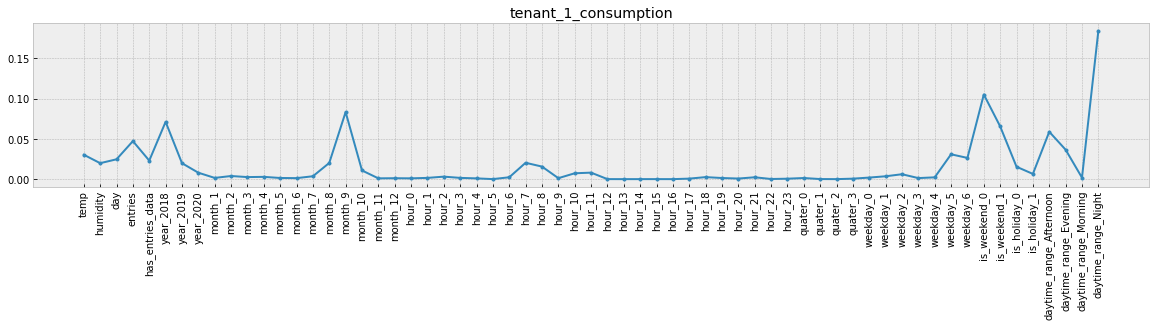

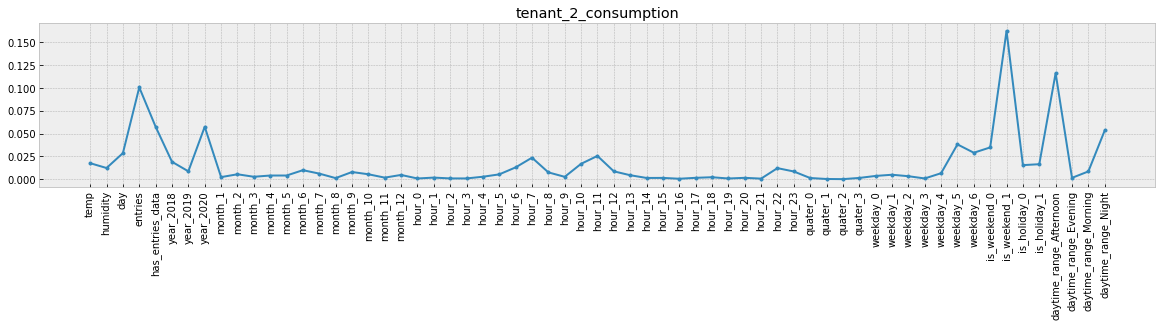

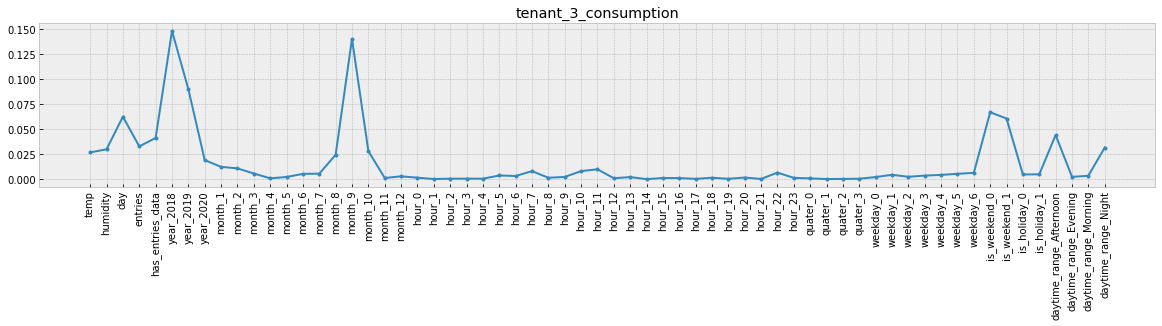

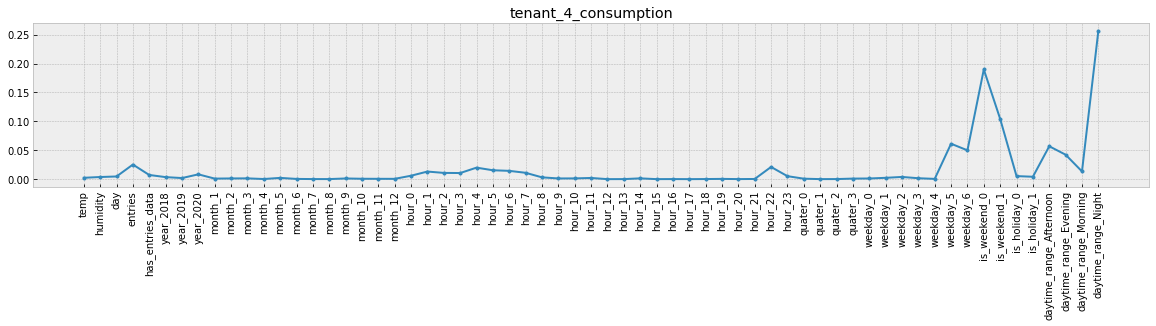

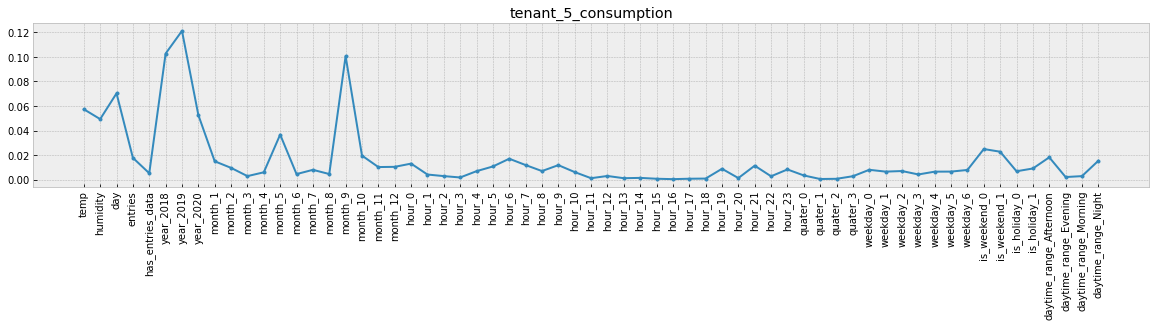

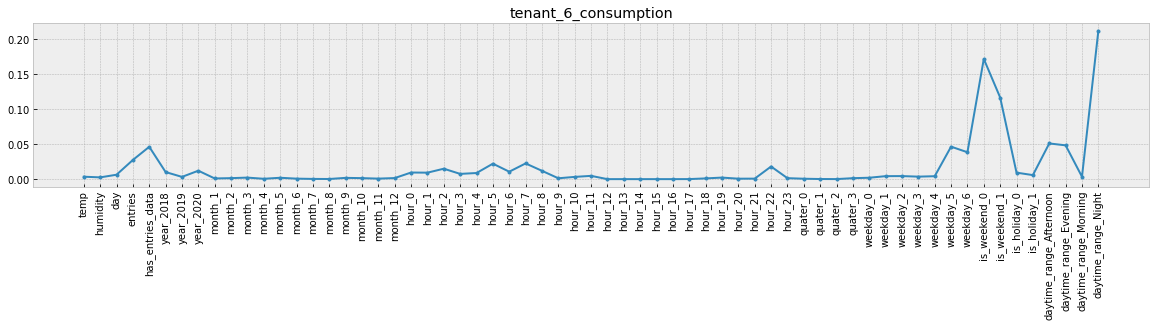

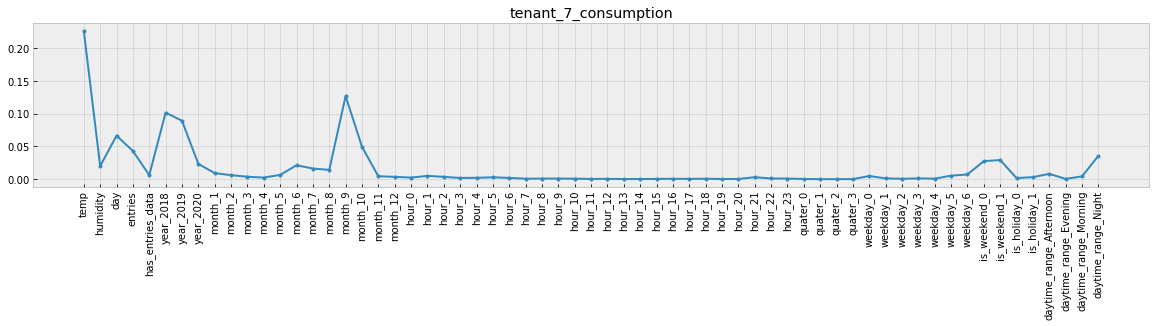

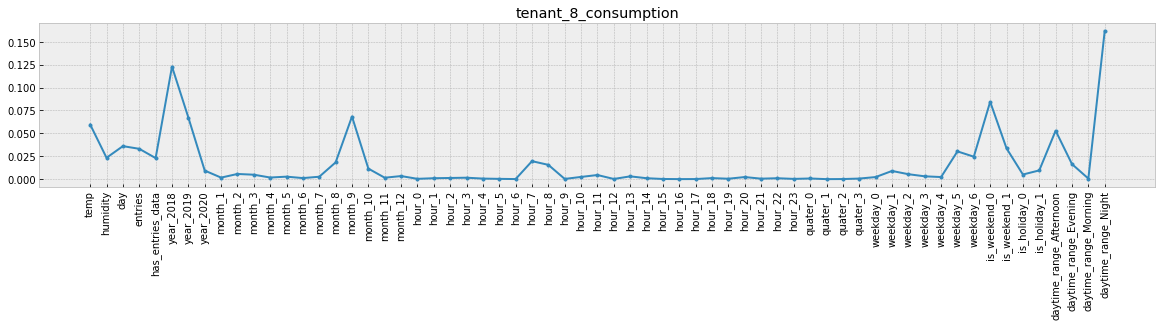

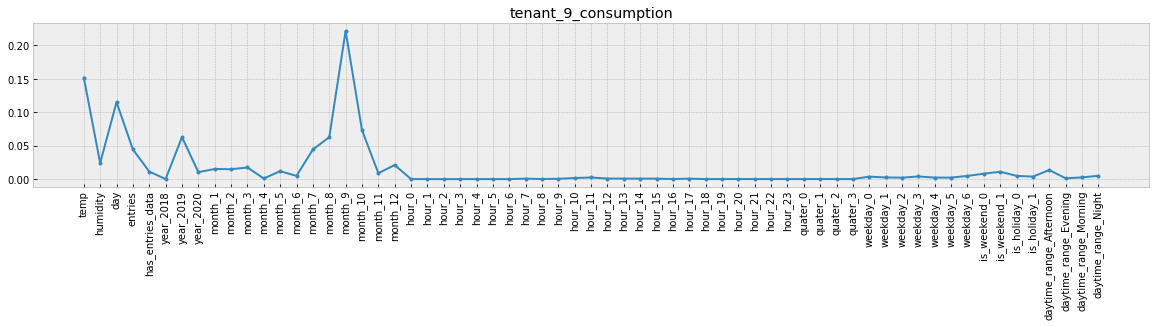

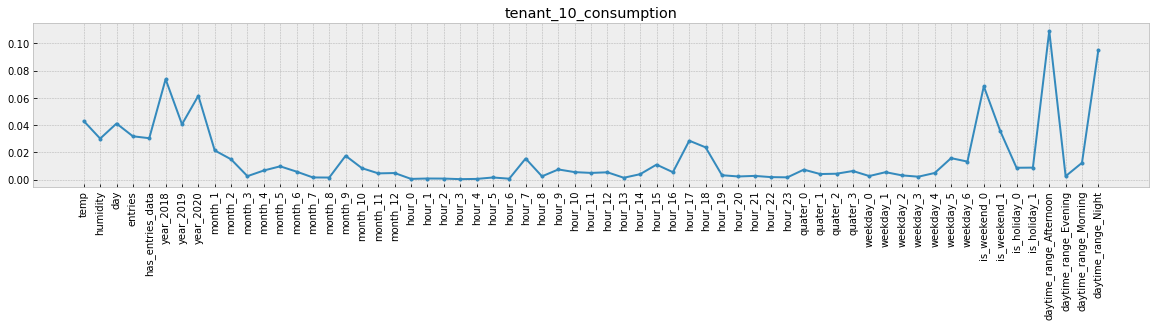

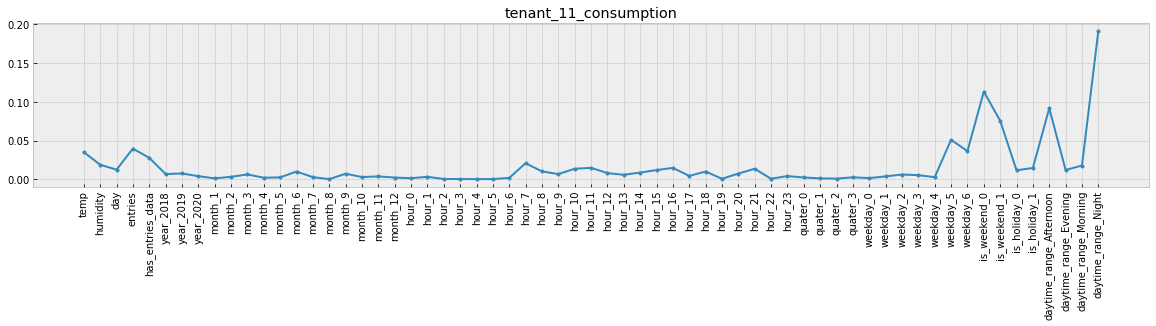

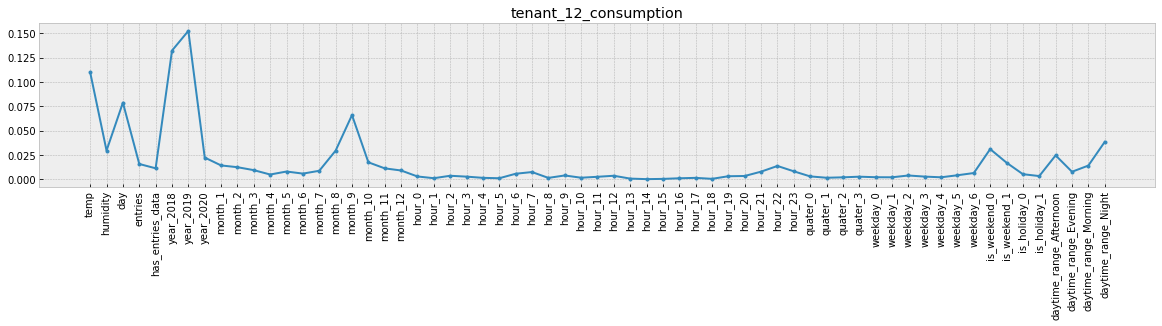

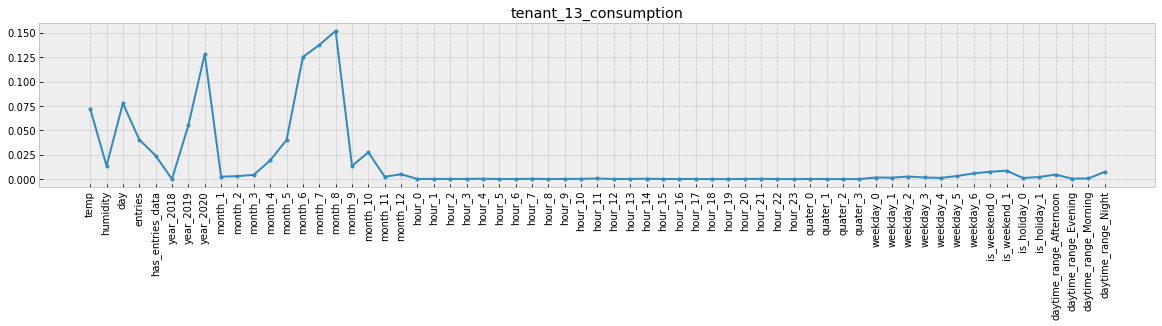

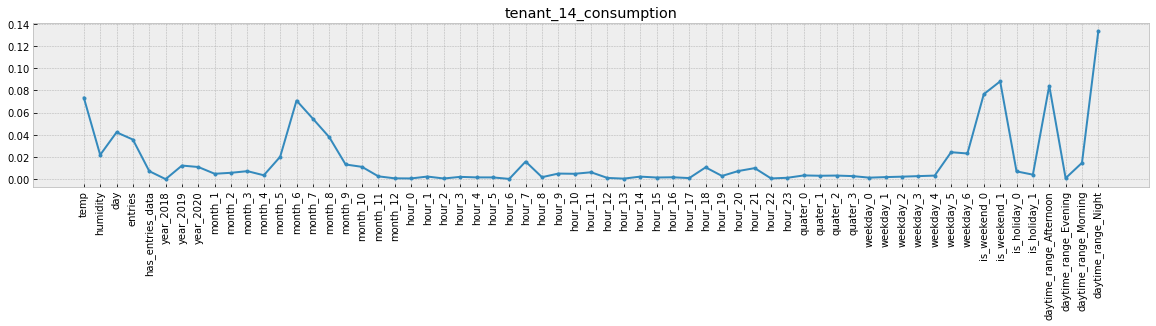

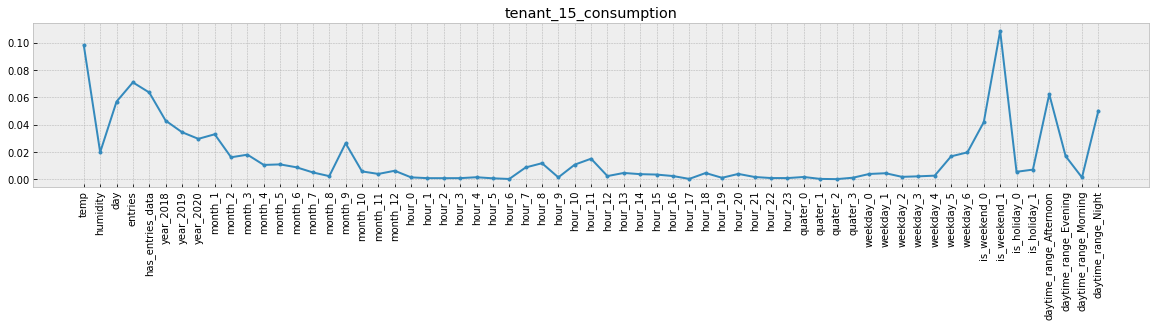

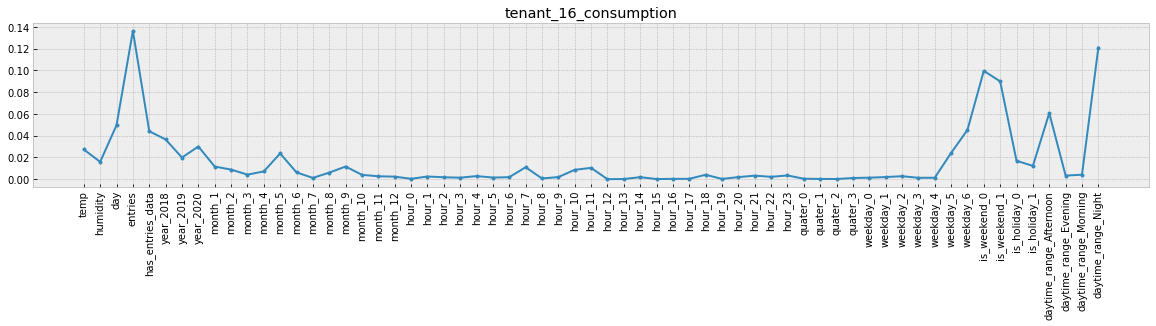

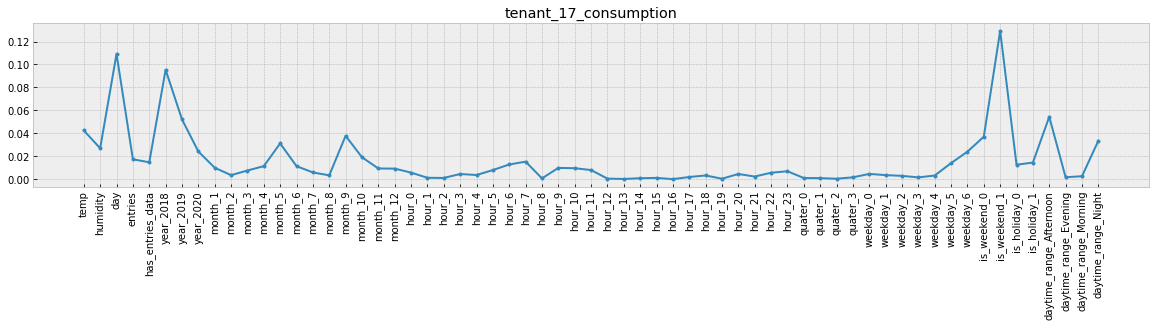

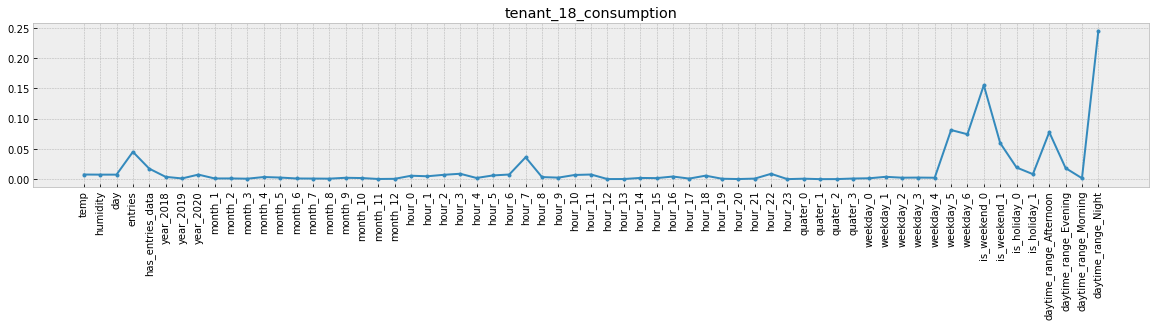

In [122]:
for i in range(1,19):
    plt.figure(figsize=(20,3))
    plt.plot(X_tests[i-1].columns, gb_models[i-1].feature_importances_, '.-')
    plt.xticks(rotation=90)
    plt.title('tenant_'+str(i)+'_feature_importance')
    plt.show()

In [136]:
# top 3
imp_features = pd.DataFrame(columns = ['tenant', 'top 1', 'top 2', 'top 3'])
for i in range(1,19):
    #imp_features.loc[i-1] = [str(i)] + sorted(gb_models[i-1].feature_importances_)[:3]
    df = pd.DataFrame()
    df['feature'] = X_tests[i-1].columns.values
    df['importance'] = gb_models[i-1].feature_importances_
    imp_features.loc[i-1] = [str(i)] + df.sort_values('importance', ascending=False)['feature'].tolist()[:3]
imp_features

,tenant,top 1,top 2,top 3
0,1,daytime_range_Night,is_weekend_0,month_9
1,2,is_weekend_1,daytime_range_Afternoon,entries
2,3,year_2018,month_9,year_2019
3,4,daytime_range_Night,is_weekend_0,is_weekend_1
4,5,year_2019,year_2018,month_9
5,6,daytime_range_Night,is_weekend_0,is_weekend_1
6,7,temp,month_9,year_2018
7,8,daytime_range_Night,year_2018,is_weekend_0
8,9,month_9,temp,day
9,10,daytime_range_Afternoon,daytime_range_Night,year_2018


In [140]:
from collections import Counter
dict(Counter(imp_features['top 1'].tolist()+ imp_features['top 2'].tolist() + imp_features['top 3'].tolist()))

{'daytime_range_Night': 9,
 'is_weekend_1': 6,
 'year_2018': 7,
 'year_2019': 3,
 'temp': 4,
 'month_9': 5,
 'daytime_range_Afternoon': 4,
 'month_8': 1,
 'entries': 3,
 'is_weekend_0': 7,
 'month_7': 1,
 'day': 2,
 'year_2020': 1,
 'weekday_5': 1}

In [171]:
#plot_test_predict(X_tests, y_tests, y_predicts)

In [105]:
'''from xgboost import XGBRegressor

df_error = pd.DataFrame(columns=['tenant', 'mse', 'rmse', 'std', 'max_test', 'min_test', 'avg_test', 'max_predict', 'min_predict', 'avg_predict'])
xgb_models = []
X_tests = []
y_tests = []
y_predicts = []

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    df = data_lin[['temp', 'humidity', 'day', 'entries', 'has_entries_data', 
                   'year_2018', 'year_2019', 'year_2020',
                   'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                   'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
                   'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
                   'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
                   'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
                   'quater_0' , 'quater_1', 'quater_2', 'quater_3', 
                   'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
                   'is_weekend_0', 'is_weekend_1', 'is_holiday_0', 'is_holiday_1',
                   'daytime_range_Afternoon', 'daytime_range_Evening', 'daytime_range_Morning', 'daytime_range_Night',  
                   test_col]]
    
    df = df.loc[df[test_col].first_valid_index(): df[test_col].last_valid_index()].fillna(0)
    #df = df.dropna(subset=[test_col]).fillna(0)
    #X_train, y_train, X_test, y_test = train_test_split(df, test_col, test_size=0.15)
    X_train, y_train, X_test, y_test = train_test_split_by_date(df, test_col)
    
    
    xgb = XGBRegressor(learning_rate=0.1, n_estimators=500, max_depth=4, 
                   colsample_bytree=1, objective='reg:squarederror',
                   nthread=None, min_child_weight=0, gamma=0, subsample=1, 
                   scale_pos_weight=1, seed=None, reg_alpha=0)
    xgb.fit(X_train, y_train)
    y_predict = xgb.predict(X_test)
    y_predict[y_predict<0] = 0
    
    xgb_models.append(xgb)
    X_tests.append(X_test)
    y_tests.append(y_test)
    y_predicts.append(y_predict)
    
    mse, rmse, std = error(y_test, y_predict)
    df_error.loc[i-1] = {'tenant': i, 
                         'mse': mse, 
                         'rmse':rmse, 
                         'std':std, 
                         'max_test': max(np.expm1(y_test)), 
                         'min_test': min(np.expm1(y_test)), 
                         'avg_test': round(np.mean(np.expm1(y_test)), 2), 
                         'max_predict': max(np.expm1(y_predict)).round(2), 
                         'min_predict': min(np.expm1(y_predict)).round(2), 
                         'avg_predict': round(np.mean(np.expm1(y_predict)), 2)}

df_error.loc[i, ['tenant', 'mse', 'rmse', 'std']] = ['mean', df_error['mse'].mean(), df_error['rmse'].mean(), df_error['std'].mean()]
df_error '''

"from xgboost import XGBRegressor\n\ndf_error = pd.DataFrame(columns=['tenant', 'mse', 'rmse', 'std', 'max_test', 'min_test', 'avg_test', 'max_predict', 'min_predict', 'avg_predict'])\nxgb_models = []\nX_tests = []\ny_tests = []\ny_predicts = []\n\nfor i in range(1,19):\n    test_col = 'tenant_'+str(i)+'_consumption'\n    df = data_lin[['temp', 'humidity', 'day', 'entries', 'has_entries_data', \n                   'year_2018', 'year_2019', 'year_2020',\n                   'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',\n                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',\n                   'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',\n                   'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',\n                   'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',\n                   'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', \n                   'quater_0' , 

Time Series

In [150]:
def split_train_test(series):
    series = series[series.first_valid_index():]
    train = series[series.index<'2020-07-01'].fillna(0)
    test = series[(series.index>='2020-07-01') & (series.index<'2020-08-31')].fillna(0)
    train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
    return train, test

In [151]:
def plot_test_predict(test_list, predict_list):
    for i in range(1,19):
        test = test_list[i-1]
        predict = predict_list[i-1]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
        #ax1.plot(train.index, train.values, '.')
        ax1.plot(test.index, test.values, '.')
        ax1.plot(predict.index, predict.values, '.')
        ax1.axhline(0, linewidth = 0.5, color = 'r')
        ax1.set_title('tenant '+str(i))

        #ax2.plot(train.index, train.fillna(0).cumsum(), '-')
        ax2.plot(test.index, test.cumsum(), '-')
        ax2.plot(predict.index, predict.cumsum(), '-')
        ax2.set_title('tenant '+str(i)+' cumsum') 

        plt.show()

In [152]:
from statsmodels.tsa.arima.model import ARIMA

tests = []
predictions = []
df_error = pd.DataFrame(columns=['tenant', 'mse','rmse','std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    data = merge_data[test_col]
    train, test = split_train_test(data)
    
    arima = ARIMA(train, order=(2, 1, 0))
    arima = arima.fit()
    predict = arima.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
    
    tests.append(test)
    predictions.append(predict)
    df_error.loc[i] = [i] + list(error(test, predict, expm1=False))
    
df_error.loc[i] = ['mean', df_error['mse'].mean(), df_error['rmse'].mean(), df_error['std'].mean()]
df_error 

,tenant,mse,rmse,std
1,1,0.041752,0.204333,0.000249
2,2,0.144804,0.380531,0.000234
3,3,0.012341,0.111091,0.000000
4,4,3.137293,1.771241,0.000000
5,5,0.011790,0.108581,0.000176
6,6,0.694905,0.833609,0.000176
7,7,7.616984,2.759888,0.000000
8,8,0.099862,0.316009,0.000227
9,9,0.006735,0.082065,0.000267
10,10,0.002600,0.050986,0.000258


In [155]:
from statsmodels.tsa.arima.model import ARIMA

tests = []
predictions = []
df_error = pd.DataFrame(columns=['tenant', 'mse','rmse','std'])

for i in range(1,19):
    test_col = 'tenant_'+str(i)+'_consumption'
    data = merge_data[test_col]
    train, test = split_train_test(data)
    
    arima = ARIMA(train, order=(1, 1, 0))
    arima = arima.fit()
    predict = arima.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
    
    tests.append(test)
    predictions.append(predict)
    df_error.loc[i] = [i] + list(error(test, predict, expm1=False))
    
df_error.loc[i] = ['mean', df_error['mse'].mean(), df_error['rmse'].mean(), df_error['std'].mean()]
df_error 

,tenant,mse,rmse,std
1,1,0.045225,0.212662,0.000247
2,2,0.154083,0.392534,0.000000
3,3,0.012341,0.111091,0.000000
4,4,3.137293,1.771241,0.000000
5,5,0.011789,0.108576,0.000250
6,6,0.694905,0.833610,0.000252
7,7,7.616984,2.759888,0.000000
8,8,0.095005,0.308229,0.000000
9,9,0.007432,0.086209,0.000252
10,10,0.003501,0.059167,0.000000


In [153]:
#plot_test_predict(tests, predictions)